# EDA for the HSSC paper

<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Library-imports" data-toc-modified-id="Library-imports-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Library imports</a></span></li><li><span><a href="#Data-imports" data-toc-modified-id="Data-imports-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Data imports</a></span></li><li><span><a href="#Functions" data-toc-modified-id="Functions-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Functions</a></span></li><li><span><a href="#Data-tranformations" data-toc-modified-id="Data-tranformations-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Data tranformations</a></span><ul class="toc-item"><li><span><a href="#Date-from-string-to-date-format" data-toc-modified-id="Date-from-string-to-date-format-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>Date from string to date-format</a></span></li></ul></li><li><span><a href="#Analysis" data-toc-modified-id="Analysis-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Analysis</a></span><ul class="toc-item"><li><span><a href="#Sentence-length" data-toc-modified-id="Sentence-length-5.1"><span class="toc-item-num">5.1&nbsp;&nbsp;</span>Sentence length</a></span></li></ul></li></ul></div>

# Table of Questions
4.1 Sentence length
  * Is there any pattern in the distribution of sentence length?
  * Is there any insight that we can draw from the analysis of the distribution of sentence length in relation with the sentence splitting process?

## Library imports

In [28]:
import csv
import json
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import re

from datetime import datetime as dt
from sklearn.metrics import r2_score


## Data imports

In [29]:
# Names of the columns in the database
col_names = ["id", "country", "pub lication_source", "issuing_institution", "doc_type", "date", "doc_title", "summary",
            "url", "num_sents", "min_sent_len", "max_sent_len", "avg_sent_len", "num_incentives_sbert", "supplies_sbert",
            "loan_sbert", "fine_sbert", "direct_payment_sbert", "technical_assistance_sbert", "tax_benefit_sbert",
            "num_incentives_bert", "supplies_bert", "loan_bert", "fine_bert", "direct_payment_bert", "technical_assistance_bert",
            "tax_benefit_bert"]

In [30]:
# Loading the two csv files and merging them toghether in a single dataframe.
in_path = "../input/"
files = [f"{in_path}spanish_metadata.csv", f"{in_path}english_metadata.csv"]

dfs = []

for filename in files:
    df_temp = pd.read_csv(filename, index_col=None, header=None)
    dfs.append(df_temp)

df = pd.concat(dfs, axis=0, ignore_index=True)
df.columns = col_names

In [ ]:
# Execute it only if yo want to save the contents of the whole database into an excel file
out_path = "../output/"
file_name =  "metadata.xlsx"
df.to_excel(f"{out_path}{file_name}")

In [ ]:
# Execute it only if you want to visualize the first 5 rows of the dataframe
df.head()

In [ ]:
# Execute it only of you want to ave a summary of the main descriptive statistics
df.describe()

## Functions

In [37]:
# To transform dd/mm/yyyy dates in string format to yyyy/mm/dd or viceversa
def reorder_date(string):
    elements = string.split("/")
    return(f"{elements[2]}/{elements[1]}/{elements[0]}")
        
# To standardize all dates in string format and convert them to datetime format
def standardize_date(string):
    string = string.replace("-", "/").strip()
    if re.search(r"[\d]{2}/[\d]{2}/[\d]{4}", string):
        string = reorder_date(string)
    try:
        date = dt.strptime(string, '%Y/%m/%d')
        return date
    except:
        print(f"{string}")

# To calculate the confidence interval of a series of values
# The significance values can be only 0.05 or 0.01
# The two available methods are "ci_normal", "ci_not_normal" and "2xs"
def confidence_interval(significance_value, method, list_of_values):
    methods = {"ci_normal" : 0, "ci_not_normal" : 0, "2xs" : 0}
    significances = {0.05 : 0, 0.01 : 0}
    z_values = {0.05 : 1.92, 0.01 : 2.58}
    t_values_n10 = {0.05 : 2.92, 0.01 : 6.96}
    t_values_n20 = {0.05 : 2.05, 0.01 : 3.36}
    s = np.std(list_of_values)
    
    if method not in methods:
        print(f"ERROR! The method is not properly spelled or it is not available.\nPlease select one of: \"ci_normal\", \"ci_not_normal\" or \"2xs\"")
        return
    if significance_value not in significances:
        print(f"ERROR! ThThe choosen significance value is not available.\nPlease select one of: 0.05 or 0.01")
        return
    elif method == "2xs":
        return(2*s)
    else:
        if method == "ci_normal" or len(list_of_values) > 20:
            z = z_values[significance_value]
        if method == "ci_not_normal" and len(list_of_values) <= 20:
            if len(list_of_values) <= 10:
                z = t_values_n10[significance_value]
            elif len(list_of_values) <= 20:
                z = t_values_n20[significance_value]
        return(s * z / np.sqrt(len(list_of_values)))
            
            
        
    
    

def bins_labels(bins, **kwargs):
    bin_w = (max(bins) - min(bins)) / (len(bins) - 1)
    labels = [int(x) for x in bins[1:] - 1]
    labels = [int(x) for x in bins[1:]]
    plt.xticks(np.arange(min(bins)+bin_w/2, max(bins), bin_w), labels, **kwargs)
#     plt.xlim(bins[0], bins[-1])

In [38]:
print(confidence_interval(0.05, "2xs", df["num_sents"]))
print(confidence_interval(0.05, "ci_normal", df["num_sents"]))
print(confidence_interval(0.05, "ci_not_normal", df["num_sents"]))
print(confidence_interval(0.05, "ci_not_normal", df["num_sents"][0:10]))
print(confidence_interval(0.05, "ci_not_normal", df["num_sents"][0:20]))

913.185097389973
5.878315523082763
5.878315523082763
88.34826621049221
40.78724093926309


## Data tranformations

### Date from string to date-format
The format of the date is not homogeneous on the date column\
The date is of type *string* which is not good for calculations

In the next couple of cells we will:
* Add a new column with the date in format datetime
* Standardize the date column to yyyy-mm-dd


In [16]:
# Inserting a new column called "date_time" containing the date as datetime type to easy calculations
df.insert(6, "date_time", df['date'].map(standardize_date))

In [17]:
# Transforming the date values to standardize them in the format yyyy-mm-dd
df["date"] = df["date_time"].dt.strftime("%Y-%m-%d")

## Analysis

This is the main section, it will be structured in subsections, one for each question that we want to solve using the data.\
We will use it as a common place with private secctions so that nobody modifies the code of anyone else.\
For this, what we are going to do is to share the whole notebook, but assign each of the subsections of section 4 only to one person. So, nobody should modify the code of any section which is not theirs. Of course, we can review other's people code and discuss it but do not modify it.\
We can proceed as follows.
1. When you have a new research question, start a new section (level 3 meaning three "#").
2. Choose a title.
3. Put your name under the title.
4. State the research question as clearly as you can below your name.

See one example in the next cell

### Sentence length
**Jordi Planas**\
Is there any pattern in the distribution of sentence length?\
Is there any insight that we can draw from the analysis of the distribution of sentence length in relation with the sentence splitting process?

In [40]:
var_1 = "num_sents"
var_2 = "avg_sent_len"

print(f"The document with most sentences has {df[var_1].max()} sentences\nThe document with least sentences has {df[var_1].min()} sentences")
print(f"The document with the largest average sentence length has an average sentence length of {df[var_2].max()} characters")
print(f"The document with the shortest sentence length has an average sentence length of {df[var_2].min()} characters")
print(f"There are {len(df[df.num_sents == 0])} documents with 0 sentences")
print(f"There are {len(df[df.avg_sent_len == 0])} documents with an average sentence length equal to 0")

# As there are 5 documents with 0 sentences, we replace the num_sents value by 1 to avoid zero division
# We also replace the all the five values of "avg_sent_len" from 0 to 1
df[var_1].replace({0 : 1}, inplace = True)
df[var_2].replace({0 : 1}, inplace = True)

The document with most sentences has 14656 sentences
The document with least sentences has 0 sentences
The document with the largest average sentence length has an average sentence length of 101915 characters
The document with the shortest sentence length has an average sentence length of 0 characters
There are 5 documents with 0 sentences
There are 5 documents with an average sentence length equal to 0


Confidence interval as two std is 0.3706188965270075


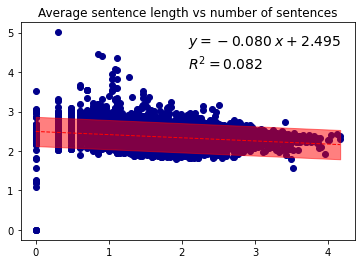

In [55]:
# Scatter plot of the log-log of number of sentences vs average length of sentence
# Sorting is needed when later we want to plat the area between the confidence intervals
sorted_df = df.sort_values(var_1)
x = np.log10(sorted_df[var_1])
y = np.log10(sorted_df[var_2])
plt.scatter(x, y , c='DarkBlue')
plt.title(f'Average sentence length vs number of sentences')

# Fitting and drawing the trend line (polynomial power 1)
z = np.polyfit(x, y, 1)
y_hat = np.poly1d(z)(x)

plt.plot(x, y_hat, "r--", lw=1)

# Plotting the equation of the line and the r2
text = f"$y={z[0]:0.3f}\;x{z[1]:+0.3f}$\n$R^2 = {r2_score(y,y_hat):0.3f}$"
plt.gca().text(0.50, 0.95, text,transform=plt.gca().transAxes,
     fontsize=14, verticalalignment='top') 

# Calculating the confidence interval and plotting it at 0.99 confidence (for this confidence value the t value is 2.58)
ci = confidence_interval(0.05, "2xs", y)
plt.fill_between(x, (y_hat-ci), (y_hat+ci), color='r', alpha=.5)
print(f"Confidence interval as two std is {ci}")

In [ ]:
Model = "simple_transformers"
lower = 1
set_bins = 20
bin_size = 1
font_size = 30
x_label = "number of incentives"
y_label = "Number of douments"
upper = (bin_size * set_bins) + lower

if Model == "BERT":
    series = df_1[(df_1["number_of_incentives"] >= lower) & (df_1["number_of_incentives"] <= upper_limit)].number_of_incentives
else:
    series = df_2[(df_2["number_of_incentives"] >= lower) & (df_2["number_of_incentives"] <= upper_limit)].number_of_incentives

fig, ax = plt.subplots(figsize=(20, 15))
counts, bins, patches = ax.hist(series, bins = num_bins, facecolor='#ffae00', edgecolor='gray')

ax.set_title(f'Number of incentives per document\n{language} dataset\n{Model}')
plt.rc('font', size=font_size)  
bins_labels(bins, fontsize=font_size, rotation=90)
plt.xlabel(x_label, labelpad = 30)
plt.ylabel(y_label, labelpad = 30)
# ax.set_xticks(bins + 1)
plt.show()


In [ ]:
var_1 = "n_sentences"
var_2 = "avg_sent_length"
n_sentences = pd.Series(dictionary["avg_sent_length"])

n_sentences.plot.hist(grid=True, bins=10, rwidth=0.9,
                       color='#607c8e')
print(f"The longest sentence has {max(n_sentences)} characters")
print(f"The shortest sentence has {min(n_sentences)} characters")

In [ ]:
lower = 65
set_bins = 20
bin_size = 60
font_size = 30
x_label = "Length of sentence in characters"
y_label = "Number of douments"
upper = (bin_size * set_bins) + lower
# fig_width = (3 * set_bins * bin_size) / 20
n_sentences_ = n_sentences[(n_sentences >= lower) & (n_sentences <= upper)]

fig, ax = plt.subplots(figsize=(20, 15))
counts, bins, patches = ax.hist(n_sentences_, bins = set_bins, facecolor='#ffae00', edgecolor='gray')

# ax = n_sentences_.plot.hist(grid=True, bins=bins, rwidth=0.9, color='#ffae00')
ax.set_title(f'Average sentence length sentences\n{language} dataset')
plt.rc('font', size=font_size)  
bins_labels(bins, fontsize=font_size, rotation=90)
plt.xlabel(x_label, labelpad = 30)
plt.ylabel(y_label, labelpad = 30)
# ax.set_xticks(bins + 1)
plt.show()



In [ ]:
range_size = 20
max_value = 220

cm = 1/2.54  # centimeters in inches
fig, axs = plt.subplots(4, 3, constrained_layout = True, figsize=(35*cm, 35*cm))
counter = 0
col = -1
row = 0

for i in range(0, max_value, range_size):
#     print(i)
    col += 1
    counter += 1
#     print(f"({row}, {col})")
        
    n_sentences_ = n_sentences[(n_sentences >= i) & (n_sentences < i + 20)]
#     print(f"min: {min(n_sentences_)} -- max: {max(n_sentences_)}")


    axs[row, col].hist(n_sentences_, bins=10, color='#607c8e')#rwidth=0.9,
    axs[row, col].set_title('Number of sentences per document')
#     axs[row, col].plt.xlabel('Counts')
#     axs[row, col].plt.ylabel('Number of sentences')
#     axs[row, col].plt.grid(axis='y', alpha=0.75)
    
    if counter % 3 == 0:
        col = -1
        row += 1

In [ ]:
df